## Imports

In [144]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.manifold import TSNE

## Helper functions

In [170]:
def clean_accuracy_data(path, accuracy_column_name):
    df = pd.read_csv(path)
    df.drop(columns=["Wall time"], inplace=True)
    df.rename(columns={"Step": "Batch number", "Value": accuracy_column_name}, inplace=True)
    df[accuracy_column_name] = (df[accuracy_column_name] * 100).round(2)
    df.set_index("Batch number", inplace=True)
    return df

def plot_accuracy_data(df, type="Train", ylim=(0, 100)):
    axis = df.plot(y=["Instantaneous", "Cumulative"], figsize=(15, 5))
    axis.set_title(f"{type} batch accuracy")
    axis.set_xlabel("Batch number")
    axis.set_ylabel("Accuracy")
    axis.set_ylim(*ylim)
    axis.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    axis.xaxis.set_major_formatter(mtick.EngFormatter())
    axis.grid()

def clean_loss_data(path, loss_column_name):
    df = pd.read_csv(path)
    df.drop(columns=["Wall time"], inplace=True)
    df.rename(columns={"Step": "Batch number", "Value": loss_column_name}, inplace=True)
    df.set_index("Batch number", inplace=True)
    return df

def plot_loss_data(df, type="Train", ylim=(0, 1)):
    axis = df.plot(y=["Instantaneous", "Cumulative"], figsize=(15, 5))
    axis.set_title(f"{type} batch cross entropy loss")
    axis.set_xlabel("Batch number")
    axis.set_ylabel("Loss")
    axis.set_ylim(*ylim)
    axis.xaxis.set_major_formatter(mtick.EngFormatter())
    axis.grid()

# Adapted from https://www.kaggle.com/code/jeffd23/visualizing-word-vectors-with-t-sne
def tsne_plot(label_to_embedding, perplexity):
    labels = []
    embedding = []

    for label in label_to_embedding:
        labels.append(label)
        embedding.append(label_to_embedding[label])
    
    tsne_model = TSNE(perplexity=perplexity, n_components=2, init='pca', n_iter=5000, random_state=23)
    new_embeddings = tsne_model.fit_transform(embeddings)

    x = []
    y = []
    for embedding in new_embeddings:
        x.append(embedding[0])
        y.append(embedding[1])
        
    plt.figure(figsize=(10, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

## Result classifier

In [3]:
result_classifier = tf.keras.models.load_model("../model_artifacts/result_classifier/trained_model/saved_model/chessformer_result_classifier.keras")
result_classifier.summary()

Model: "chessformer_result_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  7395840   
                                                                 
 result_classification (Res  multiple                  37187     
 ultClassification)                                              
                                                                 
Total params: 7433027 (28.35 MB)
Trainable params: 7433027 (28.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


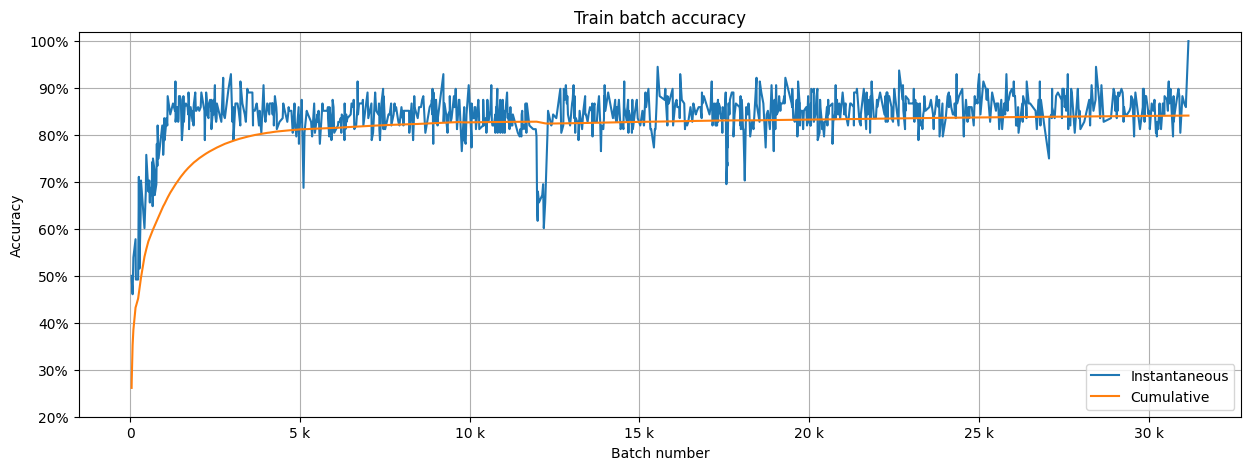

In [99]:
train_inst_acc = clean_accuracy_data(
    "../model_artifacts/result_classifier/training_metrics/train/instantaneous_batch_accuracy_epoch1.csv",
    "Instantaneous"
)
train_cum_acc = clean_accuracy_data(
    "../model_artifacts/result_classifier/training_metrics/train/cumulative_batch_accuracy_epoch1.csv",
    "Cumulative"
)

train_acc = train_inst_acc.join(train_cum_acc)

plot_accuracy_data(train_acc, type="Train", ylim=(20,102))

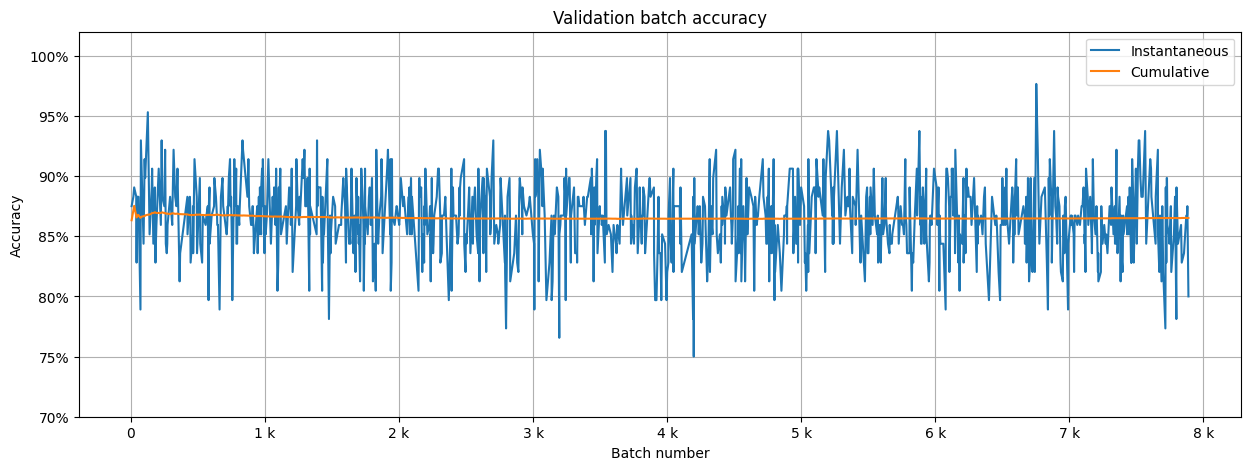

In [100]:
val_inst_acc = clean_accuracy_data(
    "../model_artifacts/result_classifier/training_metrics/validation/instantaneous_batch_accuracy_epoch1.csv",
    "Instantaneous"
)
val_cum_acc = clean_accuracy_data(
    "../model_artifacts/result_classifier/training_metrics/validation/cumulative_batch_accuracy_epoch1.csv",
    "Cumulative"
)

val_acc = val_inst_acc.join(val_cum_acc)

plot_accuracy_data(val_acc, type="Validation", ylim=(70, 102))

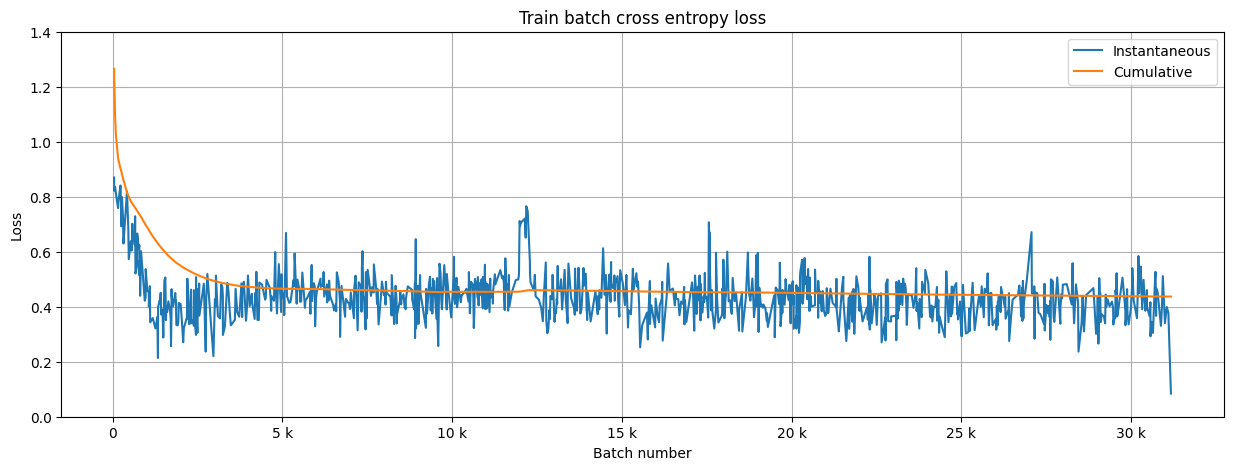

In [112]:
train_inst_loss = clean_loss_data(
    "../model_artifacts/result_classifier/training_metrics/train/instantaneous_batch_loss_epoch1.csv",
    "Instantaneous"
)
train_cum_loss = clean_loss_data(
    "../model_artifacts/result_classifier/training_metrics/train/cumulative_batch_loss_epoch1.csv",
    "Cumulative"
)

train_loss = train_inst_loss.join(train_cum_loss)

plot_loss_data(train_loss, type="Train", ylim=(0, 1.4))

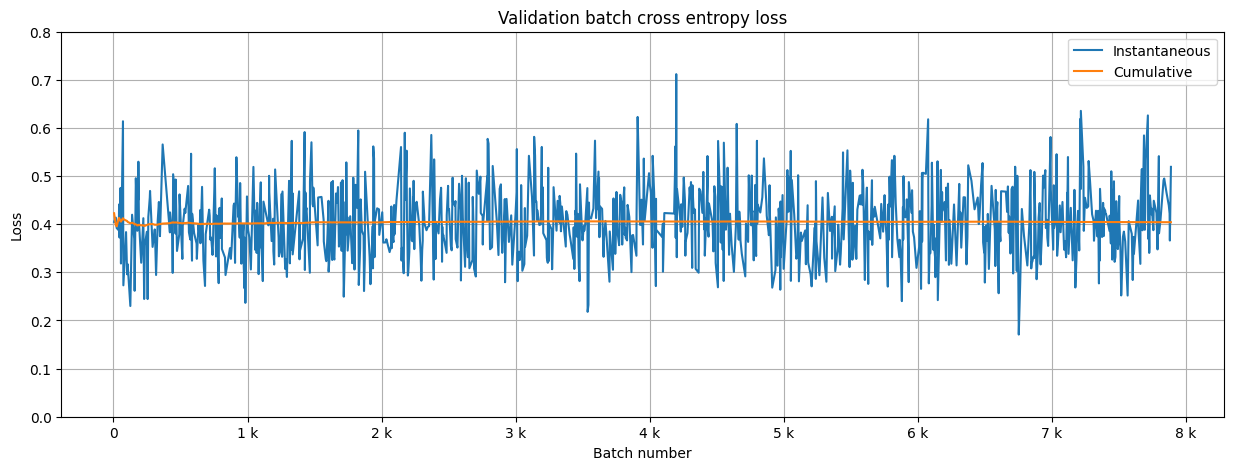

In [115]:
val_inst_loss = clean_loss_data(
    "../model_artifacts/result_classifier/training_metrics/validation/instantaneous_batch_loss_epoch1.csv",
    "Instantaneous"
)
val_cum_loss = clean_loss_data(
    "../model_artifacts/result_classifier/training_metrics/validation/cumulative_batch_loss_epoch1.csv",
    "Cumulative"
)

val_loss = val_inst_loss.join(val_cum_loss)

plot_loss_data(val_loss, type="Validation", ylim=(0, 0.8))

In [142]:
PIECES = ["p", "n", "b", "r", "q", "k"]
RANK_NAMES = ["1", "2", "3", "4", "5", "6", "7", "8"]
FILE_NAMES = ["a", "b", "c", "d", "e", "f", "g", "h"]
SQUARES = [f + r for r in RANK_NAMES for f in FILE_NAMES]
PROMOTIONS = ["-", "=n", "=b", "=r", "=q"]
POSSIBLE_TOKENS = PIECES + SQUARES + PROMOTIONS

print("Number of tokens:", len(POSSIBLE_TOKENS))

Number of tokens: 75


In [156]:
encoder = result_classifier.get_layer(index=0)
embeddings = encoder.input_embedding_layer.get_weights()[0]
print("Original embedding matric shape:", embeddings.shape)
# The first and second embeddings correspond to the empty string and UNK, respectively
# Excluding them here
embeddings = embeddings[2:]
print("Excluding non-chess tokens:", embeddings.shape)

Original embedding matric shape: (77, 512)
Excluding non-chess tokens: (75, 512)


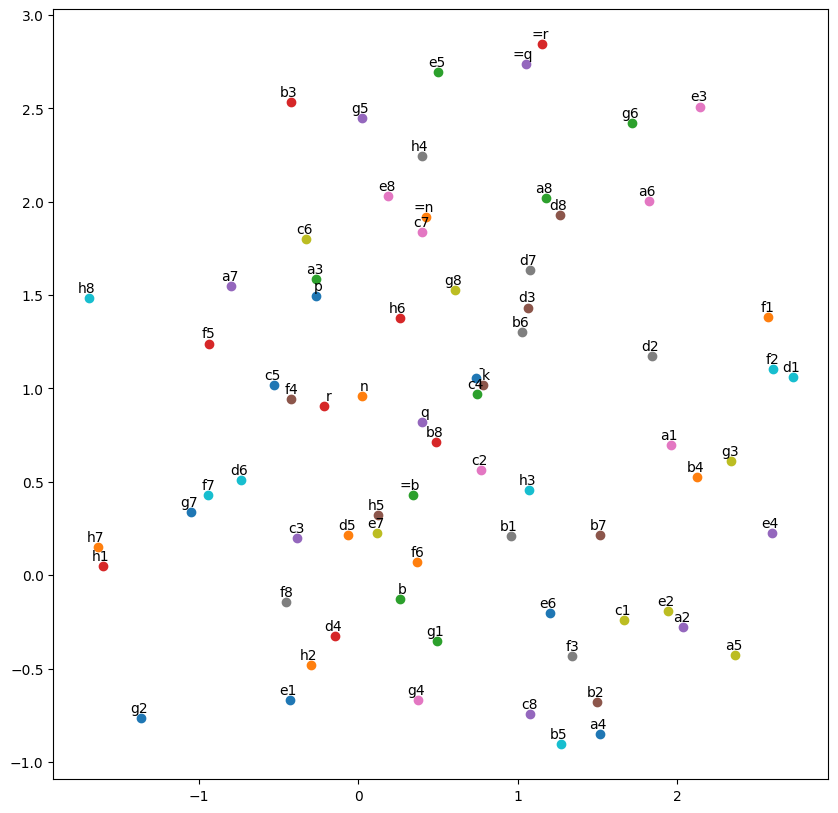

In [171]:
label_to_embedding = {label: embedding for label, embedding in zip(POSSIBLE_TOKENS, embeddings)}

tsne_plot(label_to_embedding, 40)